In [8]:
import numpy as np
import pandas as pd
import emcee
import corner
from scipy.optimize import minimize
from multiprocessing import Pool
import time
import matplotlib.pyplot as plt

from fit_just_early_lc import prep_light_curve

from corner_hack import corner_hack
from light_curve_plot import f_t, plot_both_filt

In [2]:
%matplotlib notebook

In [6]:
info_path = "../../forced_lightcurves/sample_lc_v2/"
salt_df = pd.read_csv(info_path + "../../Nobs_cut_salt2_spec_subtype.csv")

# Change of Variables


Broadly speaking, we are building models of the form $f = A t^\alpha$ in order to constrain the rising power-law index of the exploding SN. In this form, however, it is often/always the case that the MCMC sampler produces a very strong degeneracy between $A$ and $\alpha$, and to a lesser extent $t_0$, as well. (I hypothesize that this also partially explains the really really small acceptance fractions for the model.)

It is straight-forward, however, to show that this degeneracy largely disappears under the variable transformation:

$$A^\prime = A\times10^\alpha$$

From the Jacobian for this transformation we find that: 

$$Q(A^\prime, \alpha^\prime) = 10^{-\alpha} P(A, \alpha)$$

which is satisfied if:

$$P(A, \alpha) \propto 1/A$$

This is known as Jeffrey's prior, it is typically used for variables that ought to be scale invariant, and we can incorporate it here to get nicer corner plots than what we were previously able to achieve (and also hopefully faster convergence). 

In [308]:
# multiplier term for the uncertainties
def lnlike_big_unc(theta, f, t, f_err):
    t_0, a, a_prime, alpha_r, f_sigma = theta

    pre_exp = np.logical_not(t > t_0)
    model = -np.inf*np.ones_like(f)
    model[pre_exp] = a
    
    time_term = (t[~pre_exp] - t_0)
    model[~pre_exp] = a + a_prime * (time_term)**alpha_r * 10.**(-alpha_r)
    assert np.all(model > -np.inf),"fewer model values than flux values\n{}\n{}\na{}A'{}alpha{}f_sigma{}".format(model, time_term,a,a_prime,alpha_r,f_sigma)
    
    ln_l = -0.5*np.sum((f - model)**2 / ((f_sigma*f_err)**2)) - np.sum(np.log(f_sigma*f_err)) - 0.5*len(model)*np.log(np.sqrt(2*np.pi))
    return ln_l

def nll_big_unc(theta, flux, time, flux_err):
    return -1*lnlike_big_unc(theta, flux, time, flux_err)

#Define priors on parameters  
def lnprior_big_unc(theta):
    t_0, a, a_prime, alpha_r, f_sigma = theta
    if (a_prime < 0 or 
        f_sigma < 0 or 
        t_0 < -100 or
        t_0 > 0 or 
        alpha_r < 0 or
        alpha_r > 1e8 or
        a < -1e8 or
        a > 1e8):
        return -np.inf
    else:
        return -np.log(a_prime) - np.log(f_sigma) - alpha_r*np.log(10)

def lnposterior_big_unc(theta, flux, time, flux_err):
    lnp = lnprior_big_unc(theta)
    if not np.isfinite(lnp):
        return -np.inf
    lnl = lnlike_big_unc(theta, flux, time, flux_err)
    if not np.isfinite(lnl):
        return -np.inf
    return lnl + lnp

In [309]:
def multifcqfid_lnlike_big_unc(theta, f, t, f_err, fcqfid_arr):
    
    n_fcqid = len(np.unique(fcqfid_arr))
    n_filt = len(np.unique(np.unique(fcqfid_arr) % 10))

    if len(theta) != 1 + 2*n_filt + 2*n_fcqid:
        raise RuntimeError('The correct number of parameters were not included')

    ln_l = 0
    for fcqfid_num, fcqfid in enumerate(np.unique(fcqfid_arr)):
        filt = int(fcqfid % 10)

        theta_fcqfid = np.array([theta[0], theta[1 + 2*n_filt + 2*fcqfid_num], 
                                 theta[2*filt-1], theta[2*filt],
                                 theta[2 + 2*n_filt + 2*fcqfid_num]])
        fcqfid_obs = np.where(fcqfid_arr == fcqfid)
        f_fcqfid = f[fcqfid_obs]
        t_fcqfid = t[fcqfid_obs]
        f_err_fcqfid = f_err[fcqfid_obs]
        ln_l += lnlike_big_unc(theta_fcqfid, f_fcqfid, t_fcqfid, f_err_fcqfid)
    
    return ln_l

def multifcqfid_nll_big_unc(theta, f, t, f_err, fcqfid_arr):
    return -1*multifcqfid_lnlike_big_unc(theta, f, t, f_err, fcqfid_arr)

def multifcqfid_lnprior_big_unc(theta, fcqfid_arr):
    
    n_fcqid = len(np.unique(fcqfid_arr))
    n_filt = len(np.unique(np.unique(fcqfid_arr) % 10))

    if len(theta) != 1 + 2*n_filt + 2*n_fcqid:
        raise RuntimeError('The correct number of parameters were not included')

    ln_p = 0
    for fcqfid_num, fcqfid in enumerate(np.unique(fcqfid_arr)):
        filt = int(fcqfid % 10)

        theta_fcqfid = np.array([theta[0], theta[1 + 2*n_filt + 2*fcqfid_num], 
                                 theta[2*filt-1], theta[2*filt],
                                 theta[2 + 2*n_filt + 2*fcqfid_num]])
        ln_p += lnprior_big_unc(theta_fcqfid)
    return ln_p

def multifcqfid_lnposterior_big_unc(theta, f, t, f_err, fcqfid_arr):
    lnp = multifcqfid_lnprior_big_unc(theta, fcqfid_arr)
    if not np.isfinite(lnp):
        return -np.inf
    lnl = multifcqfid_lnlike_big_unc(theta, f, t, f_err, fcqfid_arr)
    if not np.isfinite(lnl):
        return -np.inf
    return lnl + lnp

### Get the light curve to fit the model

In [310]:
thin_by = 250
rel_flux_cutoff = 0.4
t_fl = 18

sn = 'ZTF18abaxlpi'

t_max = float(salt_df['t0_g_adopted'][salt_df['name'] == sn].values)
z = float(salt_df['z_adopt'][salt_df['name'] == sn].values)
g_max = float(salt_df['fratio_gmax_2adam'][salt_df['name'] == sn].values)
r_max = float(salt_df['fratio_rmax_2adam'][salt_df['name'] == sn].values)

t_data, f_data, f_unc_data, fcqfid_data = prep_light_curve(info_path+"{}_force_phot.h5".format(sn),
                                                                     t_max=t_max, 
                                                                     z=z,
                                                                     g_max=g_max,
                                                                     r_max=r_max,
                                                                     rel_flux_cutoff=rel_flux_cutoff,
                                                          flux_scale=100)

In [313]:
n_filt = len(np.unique(np.unique(fcqfid_data) % 10))
guess_0 = np.append([-t_fl] + [6e1, 2]*n_filt,
                    [1,1]*len(np.unique(fcqfid_data)))

ml_res = minimize(multifcqfid_nll_big_unc, guess_0, method='Powell', # Powell method does not need derivatives
              args=(f_data, t_data, f_unc_data, fcqfid_data))
ml_guess = ml_res.x

/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log
  del sys.path[0]


In [314]:
ml_guess

array([-18.19507469,  71.52679566,   2.65156662,  65.52987739,
         2.41277818,   0.10075856,   1.15548453,  -0.34478182,
         1.18112481])

In [315]:
#initial position of walkers
ndim = len(ml_guess)
nfac = [10**(-2.5)]*ndim
nwalkers = 100

rand_pos = [1 + nfac*np.random.randn(ndim) for i in range(nwalkers)]
pos = ml_guess*rand_pos

with Pool(4) as pool:
    burn_sampler = emcee.EnsembleSampler(nwalkers, ndim, 
                                        multifcqfid_lnposterior_big_unc, 
                                        args=(f_data, t_data, 
                                              f_unc_data, fcqfid_data),
                                        pool=pool)
    burn_sampler.run_mcmc(pos, nsteps=5000, 
                        thin_by=1, progress=True)
    flat_burn_chain = burn_sampler.get_chain(flat=True)
    flat_burn_prob = np.argmax(burn_sampler.get_log_prob(flat=True))
    max_prob = flat_burn_chain[flat_burn_prob]
    pos = max_prob*rand_pos

100%|██████████| 5000/5000 [00:49<00:00, 100.42it/s]


In [316]:
max_prob

array([-17.52652764,  77.366311  ,   2.24628332,  71.55389946,
         2.09700424,   0.11089663,   1.13959568,  -0.35644078,
         1.20528176])

<IPython.core.display.Javascript object>


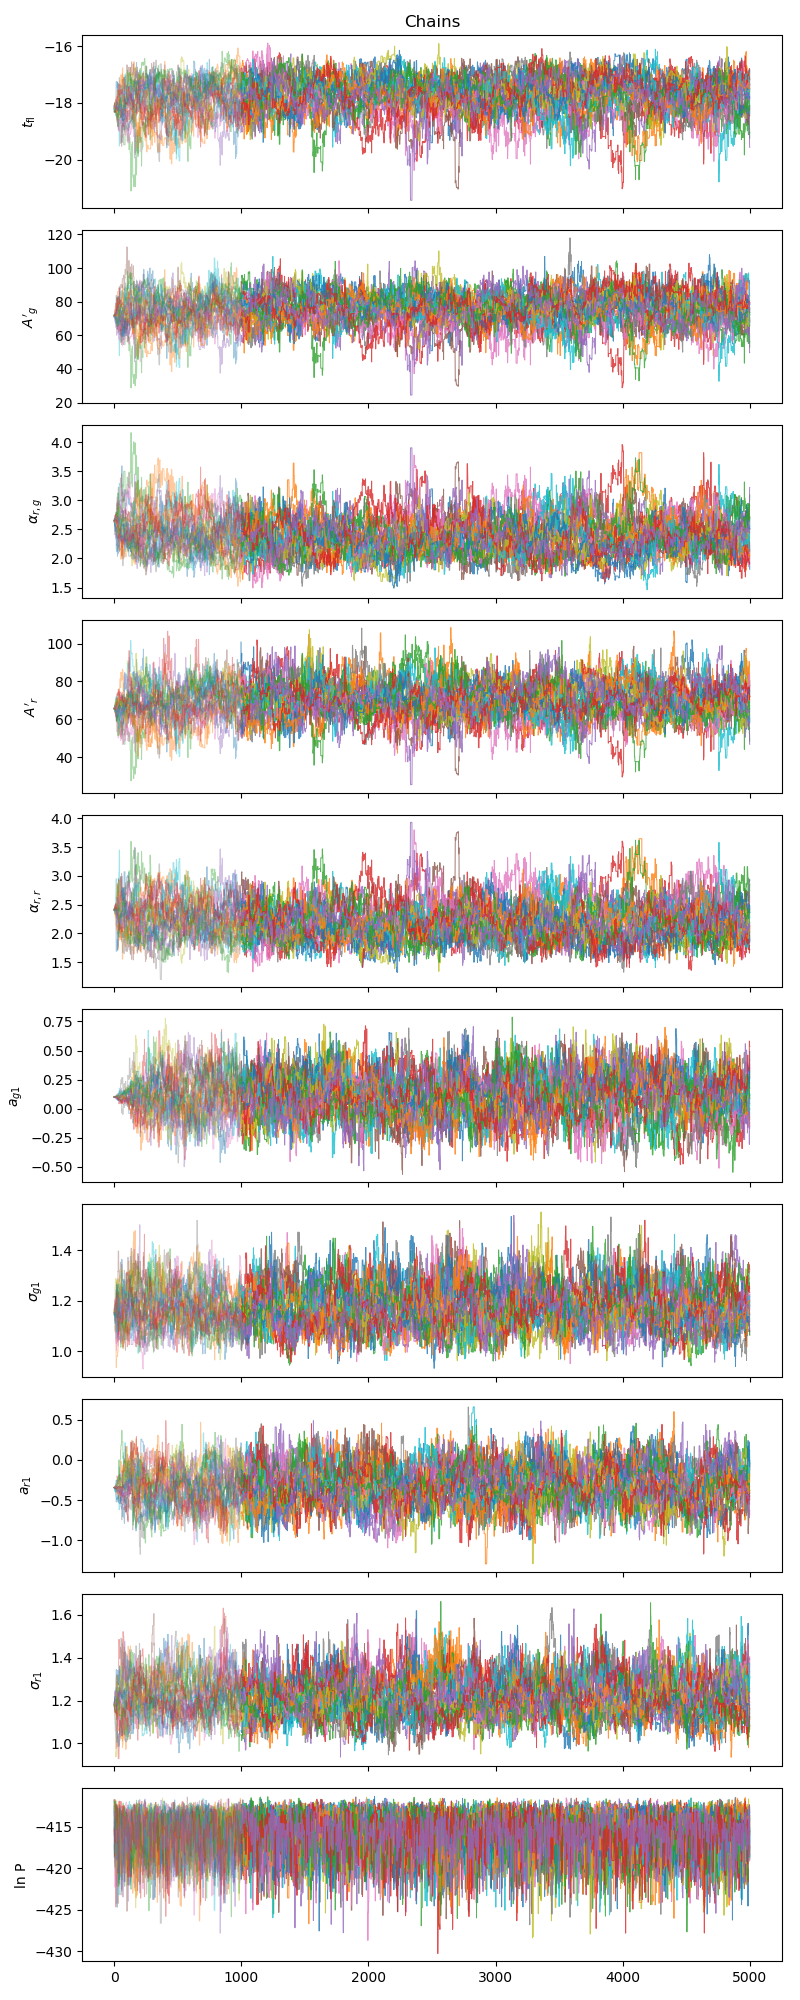

In [317]:
plotChains(burn_sampler, 1000, gr_paramsNames, nplot=25)
plt.tight_layout()

<IPython.core.display.Javascript object>


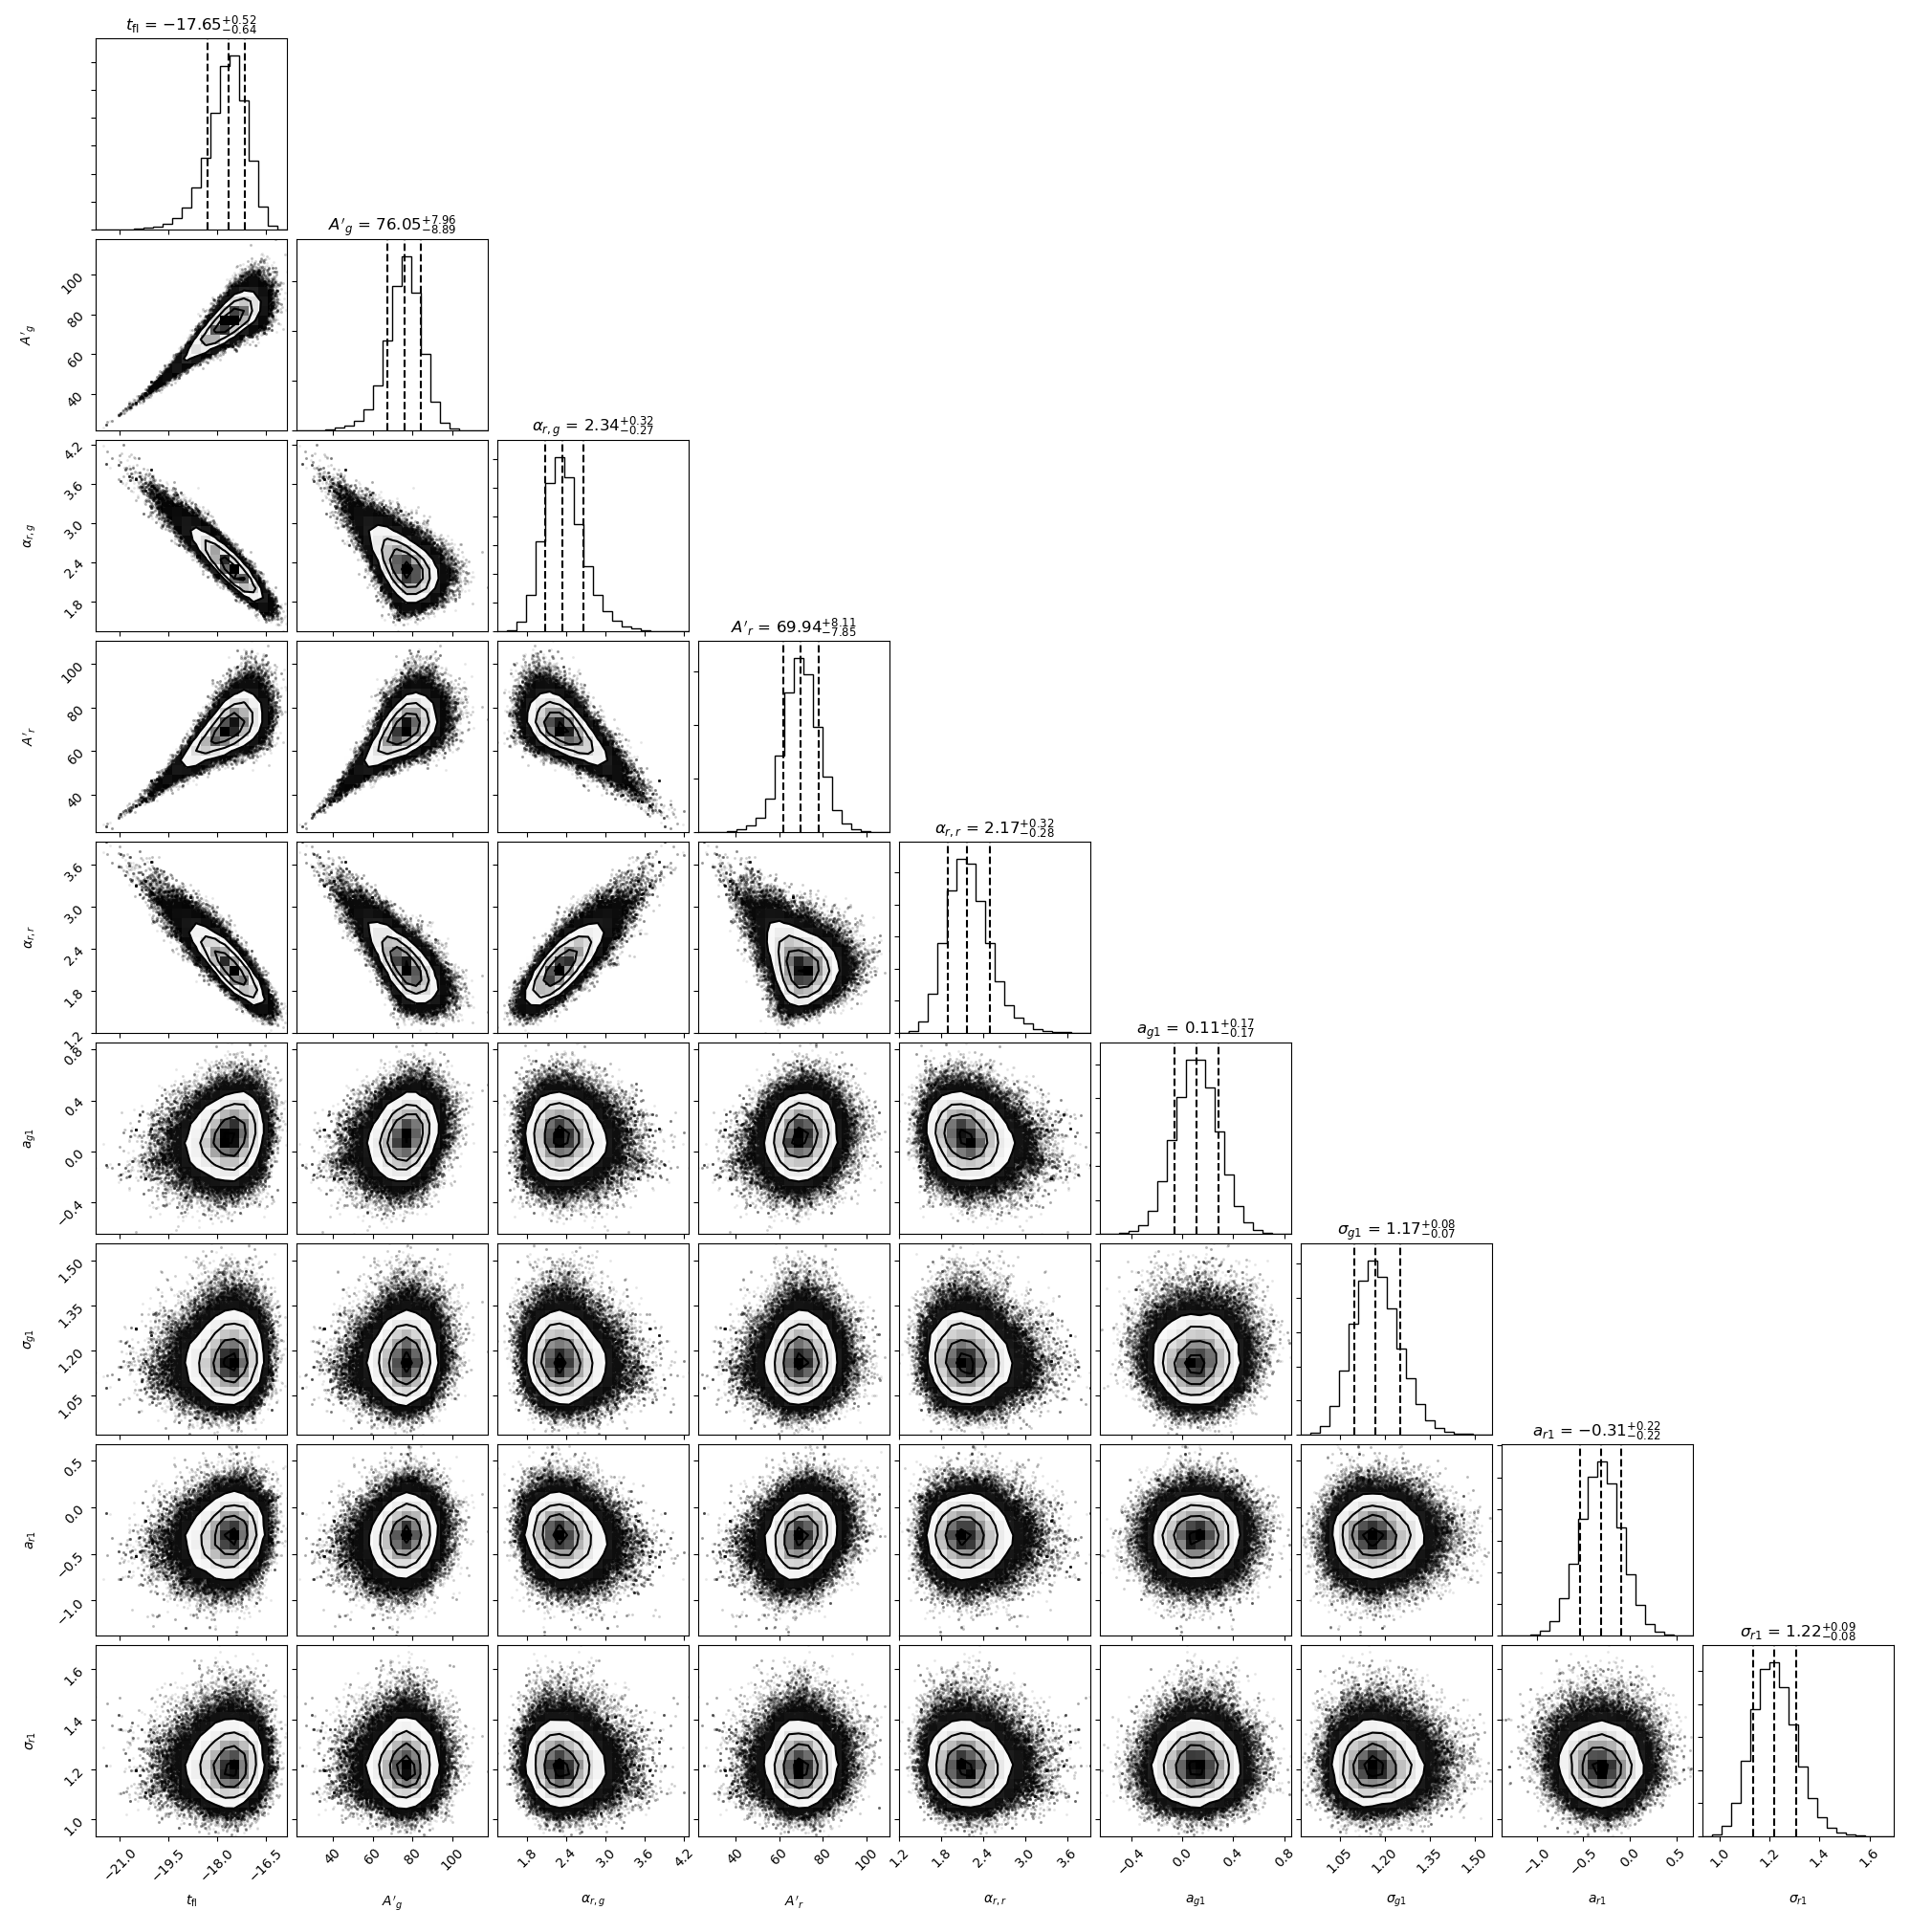

In [319]:
makeCorner(burn_sampler, 2000, gr_paramsNames)

<IPython.core.display.Javascript object>


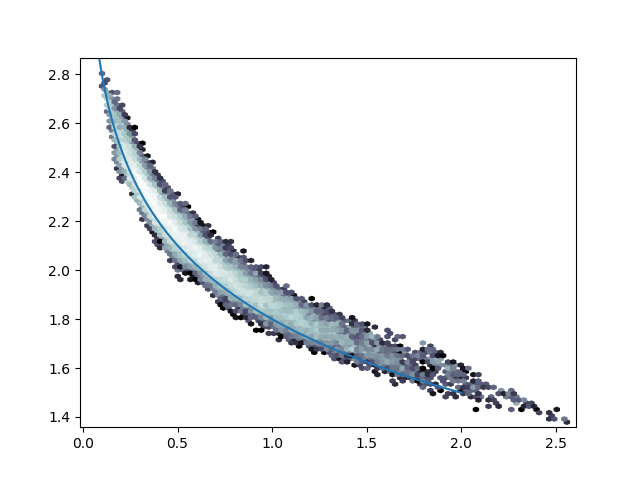

/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':


In [307]:
burn_samples = burn_sampler.get_chain(discard=3000, flat=True)
t0 = burn_samples[:,0]
A = burn_samples[:,3]
alpha = burn_samples[:,4]
plt.figure()
plt.hexbin(A, alpha, mincnt=1, bins='log', cmap='bone')
plt.hexbin(A*10**(alpha), alpha, mincnt=1, bins='log', cmap='bone')

grid = np.linspace(0.01,2,1e7)
plt.plot(grid, -np.log10(grid) + 1.8)

In [320]:
with Pool(4) as pool:        
    sampler = emcee.EnsembleSampler(nwalkers, ndim, 
                                        multifcqfid_lnposterior_big_unc, 
                                        args=(f_data, t_data, 
                                              f_unc_data, fcqfid_data),
                                        pool=pool)

    old_tau = np.inf
    for sample in sampler.sample(pos, 
                                 iterations=400, 
                                 thin_by=250, progress=True):
        if ((sampler.iteration <= int(1e3/thin_by)) and 
             sampler.iteration % int(250/thin_by)):
            continue
        elif ((int(1e3/thin_by) < sampler.iteration <= int(1e4/thin_by)) 
              and sampler.iteration % int(1e3/thin_by)):
            continue
        elif ((int(1e4/thin_by) < sampler.iteration <= int(1e5/thin_by)) 
              and sampler.iteration % int(1e4/thin_by)):
            continue
        elif ((int(1e5/thin_by) < sampler.iteration) and 
              sampler.iteration % int(2e4/thin_by)):
            continue

        tstart = time.time()
        tau = sampler.get_autocorr_time(tol=0)
        tend = time.time()
        steps_so_far = sampler.iteration
        print('''After {:d} steps, 
autocorrelation takes {:.3f} s ({} total FFTs)                
acceptance fraction = {:.4f}, and
tau = {}'''.format(steps_so_far, 
                   tend-tstart, nwalkers*ndim,
                   np.mean(sampler.acceptance_fraction), 
                   tau))

        # Check convergence
        converged = np.all(tau * 100 < sampler.iteration)
        converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
        if converged:
            break
        old_tau = tau

  0%|          | 249/100000 [00:02<15:17, 108.71it/s]/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in less
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in less
  0%|          | 260/100000 [00:02<16:29, 100.80it/s]

After 1 steps, 
autocorrelation takes 0.030 s (900 total FFTs)                
acceptance fraction = 0.4500, and
tau = [nan nan nan nan nan nan nan nan nan]


  1%|          | 513/100000 [00:04<16:24, 101.02it/s]

After 2 steps, 
autocorrelation takes 0.037 s (900 total FFTs)                
acceptance fraction = 0.4050, and
tau = [0. 0. 0. 0. 0. 0. 0. 0. 0.]


  1%|          | 763/100000 [00:07<18:31, 89.32it/s]

After 3 steps, 
autocorrelation takes 0.034 s (900 total FFTs)                
acceptance fraction = 0.4033, and
tau = [-1.11022302e-16  4.44089210e-16  2.22044605e-16 -2.22044605e-16
  0.00000000e+00  0.00000000e+00 -2.22044605e-16  0.00000000e+00
  2.22044605e-16]


  1%|          | 1017/100000 [00:10<17:24, 94.76it/s]

After 4 steps, 
autocorrelation takes 0.032 s (900 total FFTs)                
acceptance fraction = 0.4100, and
tau = [0.17032155 0.14853822 0.16984361 0.14971813 0.1773685  0.12348348
 0.12878286 0.15242455 0.11558515]


  2%|▏         | 2013/100000 [00:20<16:33, 98.58it/s] 

After 8 steps, 
autocorrelation takes 0.033 s (900 total FFTs)                
acceptance fraction = 0.3962, and
tau = [0.30838857 0.33371587 0.30445073 0.35699768 0.33934685 0.36770403
 0.32493473 0.29077372 0.39101969]


  3%|▎         | 3016/100000 [00:31<17:02, 94.86it/s] 

After 12 steps, 
autocorrelation takes 0.033 s (900 total FFTs)                
acceptance fraction = 0.4008, and
tau = [0.51890429 0.51199746 0.53959315 0.49488936 0.59289194 0.4860081
 0.51468191 0.55891937 0.46736129]


  4%|▍         | 4009/100000 [00:42<18:30, 86.45it/s] 

After 16 steps, 
autocorrelation takes 0.033 s (900 total FFTs)                
acceptance fraction = 0.3950, and
tau = [0.69884312 0.71185603 0.69584909 0.66447413 0.64698097 0.56972048
 0.66123793 0.5928345  0.56120075]


  5%|▌         | 5019/100000 [00:52<16:43, 94.67it/s] 

After 20 steps, 
autocorrelation takes 0.041 s (900 total FFTs)                
acceptance fraction = 0.3925, and
tau = [0.76113993 0.74068902 0.79077556 0.7559201  0.76966677 0.67868439
 0.68719357 0.63339299 0.58904189]


  6%|▌         | 6013/100000 [01:02<16:29, 95.03it/s] 

After 24 steps, 
autocorrelation takes 0.039 s (900 total FFTs)                
acceptance fraction = 0.4000, and
tau = [0.80291964 0.78796994 0.81446603 0.72248654 0.76046957 0.72158705
 0.76600121 0.66462351 0.69562539]


  7%|▋         | 7010/100000 [01:14<24:59, 62.00it/s] 

After 28 steps, 
autocorrelation takes 0.054 s (900 total FFTs)                
acceptance fraction = 0.3986, and
tau = [0.84294768 0.85466392 0.84079247 0.75208168 0.84379275 0.73001815
 0.79595175 0.70048412 0.74295532]


  8%|▊         | 8013/100000 [01:28<19:00, 80.62it/s]

After 32 steps, 
autocorrelation takes 0.037 s (900 total FFTs)                
acceptance fraction = 0.3934, and
tau = [0.91122338 0.9220258  0.89704315 0.81839825 0.91623458 0.79799585
 0.78506896 0.70566613 0.7570367 ]


  9%|▉         | 9008/100000 [01:40<19:24, 78.16it/s]

After 36 steps, 
autocorrelation takes 0.042 s (900 total FFTs)                
acceptance fraction = 0.3931, and
tau = [0.94712484 0.97916075 0.90687722 0.81097659 0.96456906 0.76603576
 0.76789473 0.75306706 0.79365943]


 10%|█         | 10014/100000 [01:53<20:54, 71.76it/s]

After 40 steps, 
autocorrelation takes 0.045 s (900 total FFTs)                
acceptance fraction = 0.3942, and
tau = [0.9787173  0.98022546 0.96635967 0.81871511 0.99101667 0.82484574
 0.80046763 0.74466639 0.74942446]


 20%|██        | 20015/100000 [03:50<16:06, 82.73it/s] 

After 80 steps, 
autocorrelation takes 0.039 s (900 total FFTs)                
acceptance fraction = 0.3977, and
tau = [1.05598706 1.03445814 1.06679572 0.96665703 1.07690897 0.97971555
 0.87991328 0.88356073 0.93050321]


 30%|███       | 30012/100000 [05:46<14:50, 78.59it/s] 

After 120 steps, 
autocorrelation takes 0.047 s (900 total FFTs)                
acceptance fraction = 0.3963, and
tau = [1.11233778 1.06503277 1.11749126 1.01427777 1.10320171 0.98278703
 0.9546397  0.99074784 0.96966118]


 40%|████      | 40014/100000 [07:39<11:00, 90.88it/s] 

After 160 steps, 
autocorrelation takes 0.042 s (900 total FFTs)                
acceptance fraction = 0.3973, and
tau = [1.15724264 1.09400103 1.16876886 1.08363441 1.12193024 1.01501477
 0.98325051 1.00981992 0.98430728]


 50%|█████     | 50019/100000 [09:27<09:13, 90.37it/s] 

After 200 steps, 
autocorrelation takes 0.044 s (900 total FFTs)                
acceptance fraction = 0.3976, and
tau = [1.19419736 1.13115083 1.20177913 1.11615368 1.15418288 1.02650666
 1.01807299 1.01110677 1.00636305]


 60%|██████    | 60017/100000 [11:12<07:28, 89.15it/s] 

After 240 steps, 
autocorrelation takes 0.043 s (900 total FFTs)                
acceptance fraction = 0.3999, and
tau = [1.18906489 1.13529682 1.19190656 1.11240327 1.15500601 1.04158784
 1.01823503 1.02184236 1.02265301]


 70%|███████   | 70011/100000 [12:56<05:48, 86.02it/s] 

After 280 steps, 
autocorrelation takes 0.052 s (900 total FFTs)                
acceptance fraction = 0.4004, and
tau = [1.19409347 1.14024292 1.1954349  1.10881887 1.16026743 1.02991982
 1.04692308 1.01666918 1.03648803]


 80%|████████  | 80012/100000 [14:40<03:37, 91.79it/s] 

After 320 steps, 
autocorrelation takes 0.050 s (900 total FFTs)                
acceptance fraction = 0.4016, and
tau = [1.21231862 1.13429062 1.21511168 1.11241987 1.17434112 1.03426993
 1.05376209 1.01848445 1.03793701]


 90%|█████████ | 90010/100000 [16:26<02:07, 78.63it/s] 

After 360 steps, 
autocorrelation takes 0.051 s (900 total FFTs)                
acceptance fraction = 0.4024, and
tau = [1.19963381 1.1365442  1.21101825 1.11420858 1.17063069 1.033527
 1.07687935 1.02572739 1.04241143]


100%|██████████| 100000/100000 [18:09<00:00, 91.77it/s]

After 400 steps, 
autocorrelation takes 0.051 s (900 total FFTs)                
acceptance fraction = 0.4025, and
tau = [1.22074862 1.14708115 1.21946546 1.13614721 1.17559812 1.03737223
 1.06794569 1.01487922 1.04408617]


In [321]:
gr_paramsNames

['$t_\\mathrm{fl}$',
 "$A'_g$",
 '$\\alpha_{r, g}$',
 "$A'_r$",
 '$\\alpha_{r, r}$',
 '$a_{g1}$',
 '$\\sigma_{g1}$',
 '$a_{r1}$',
 '$\\sigma_{r1}$']

In [322]:
gr_paramsNames=[r'$t_\mathrm{fl}$', 
             r"$A'_g$", r'$\alpha_{r, g}$', 
             r"$A'_r$", r'$\alpha_{r, r}$']

baseline_list = []
g_fcqfid_idx = 1
r_fcqfid_idx = 1
for fcqfid_num, fcqfid in enumerate(np.unique(fcqfid_data)):
    filt = int(fcqfid % 10)
    if filt == 1:
        baseline_list.append('$a_{{g{}}}$'.format(g_fcqfid_idx))
        baseline_list.append('$\sigma_{{g{}}}$'.format(g_fcqfid_idx))
        g_fcqfid_idx += 1
    elif filt == 2:
        baseline_list.append('$a_{{r{}}}$'.format(r_fcqfid_idx))
        baseline_list.append('$\sigma_{{r{}}}$'.format(r_fcqfid_idx))
        r_fcqfid_idx += 1

gr_paramsNames = gr_paramsNames + baseline_list

<IPython.core.display.Javascript object>


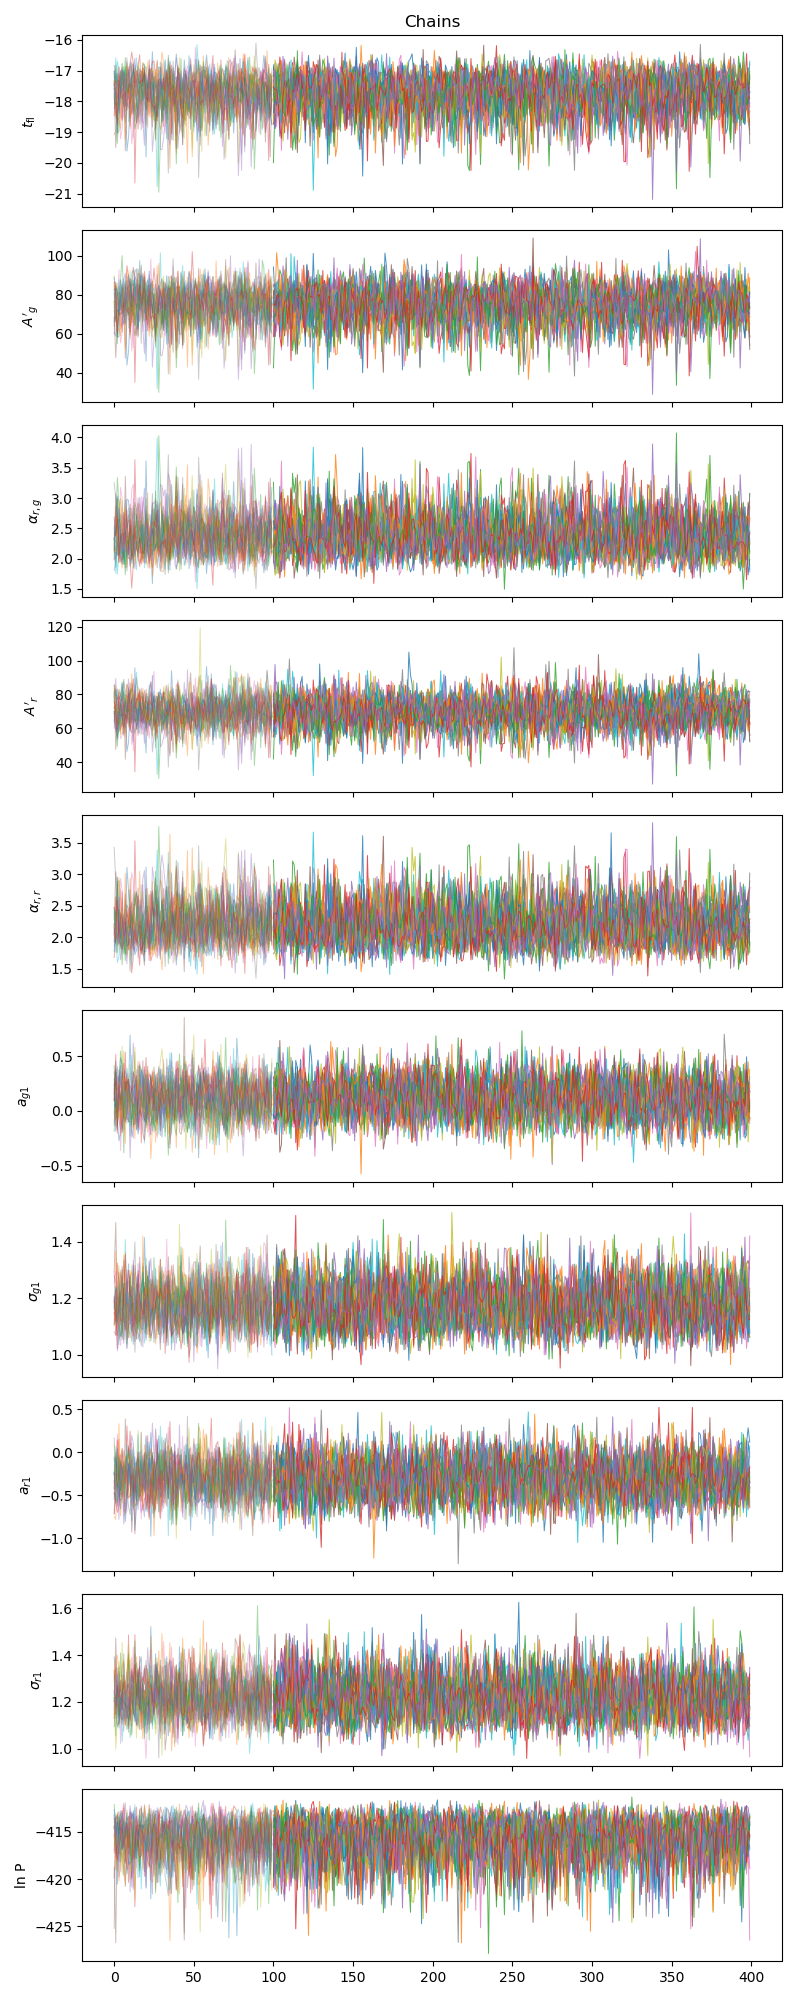

In [323]:
plotChains(sampler, 100, gr_paramsNames, nplot=25)
plt.tight_layout()

In [324]:
tau = np.max(sampler.get_autocorr_time(tol=0))
samples = sampler.get_chain(discard=int(5*tau), thin=int(tau), flat=True)
lnprob = sampler.get_log_prob(discard=int(5*tau), thin=int(tau), flat=True)

print(multifcqfid_nll_big_unc(guess_0, f_data, t_data, f_unc_data, fcqfid_data))
print(multifcqfid_nll_big_unc(ml_guess, f_data, t_data, f_unc_data, fcqfid_data))
print(multifcqfid_nll_big_unc(max_prob, f_data, t_data, f_unc_data, fcqfid_data))
print(multifcqfid_nll_big_unc(samples[np.argmax(lnprob)], f_data, t_data, f_unc_data, fcqfid_data))

print(multifcqfid_lnposterior_big_unc(guess_0, f_data, t_data, f_unc_data, fcqfid_data))
print(multifcqfid_lnposterior_big_unc(ml_guess, f_data, t_data, f_unc_data, fcqfid_data))
print(multifcqfid_lnposterior_big_unc(max_prob, f_data, t_data, f_unc_data, fcqfid_data))
print(multifcqfid_lnposterior_big_unc(samples[np.argmax(lnprob)], f_data, t_data, f_unc_data, fcqfid_data))

523.8263159649665
391.35464969521297
392.2938860781177
391.99975600490063
-541.225345461387
-411.7792998412743
-411.23106459888544
-411.17515254410074


In [325]:
samples[np.argmax(lnprob)]

array([-17.59957609,  77.21362524,   2.30837114,  71.57504403,
         2.13781931,   0.11020932,   1.13475255,  -0.3207789 ,
         1.21400846])

In [326]:
ml_guess

array([-18.19507469,  71.52679566,   2.65156662,  65.52987739,
         2.41277818,   0.10075856,   1.15548453,  -0.34478182,
         1.18112481])

<IPython.core.display.Javascript object>


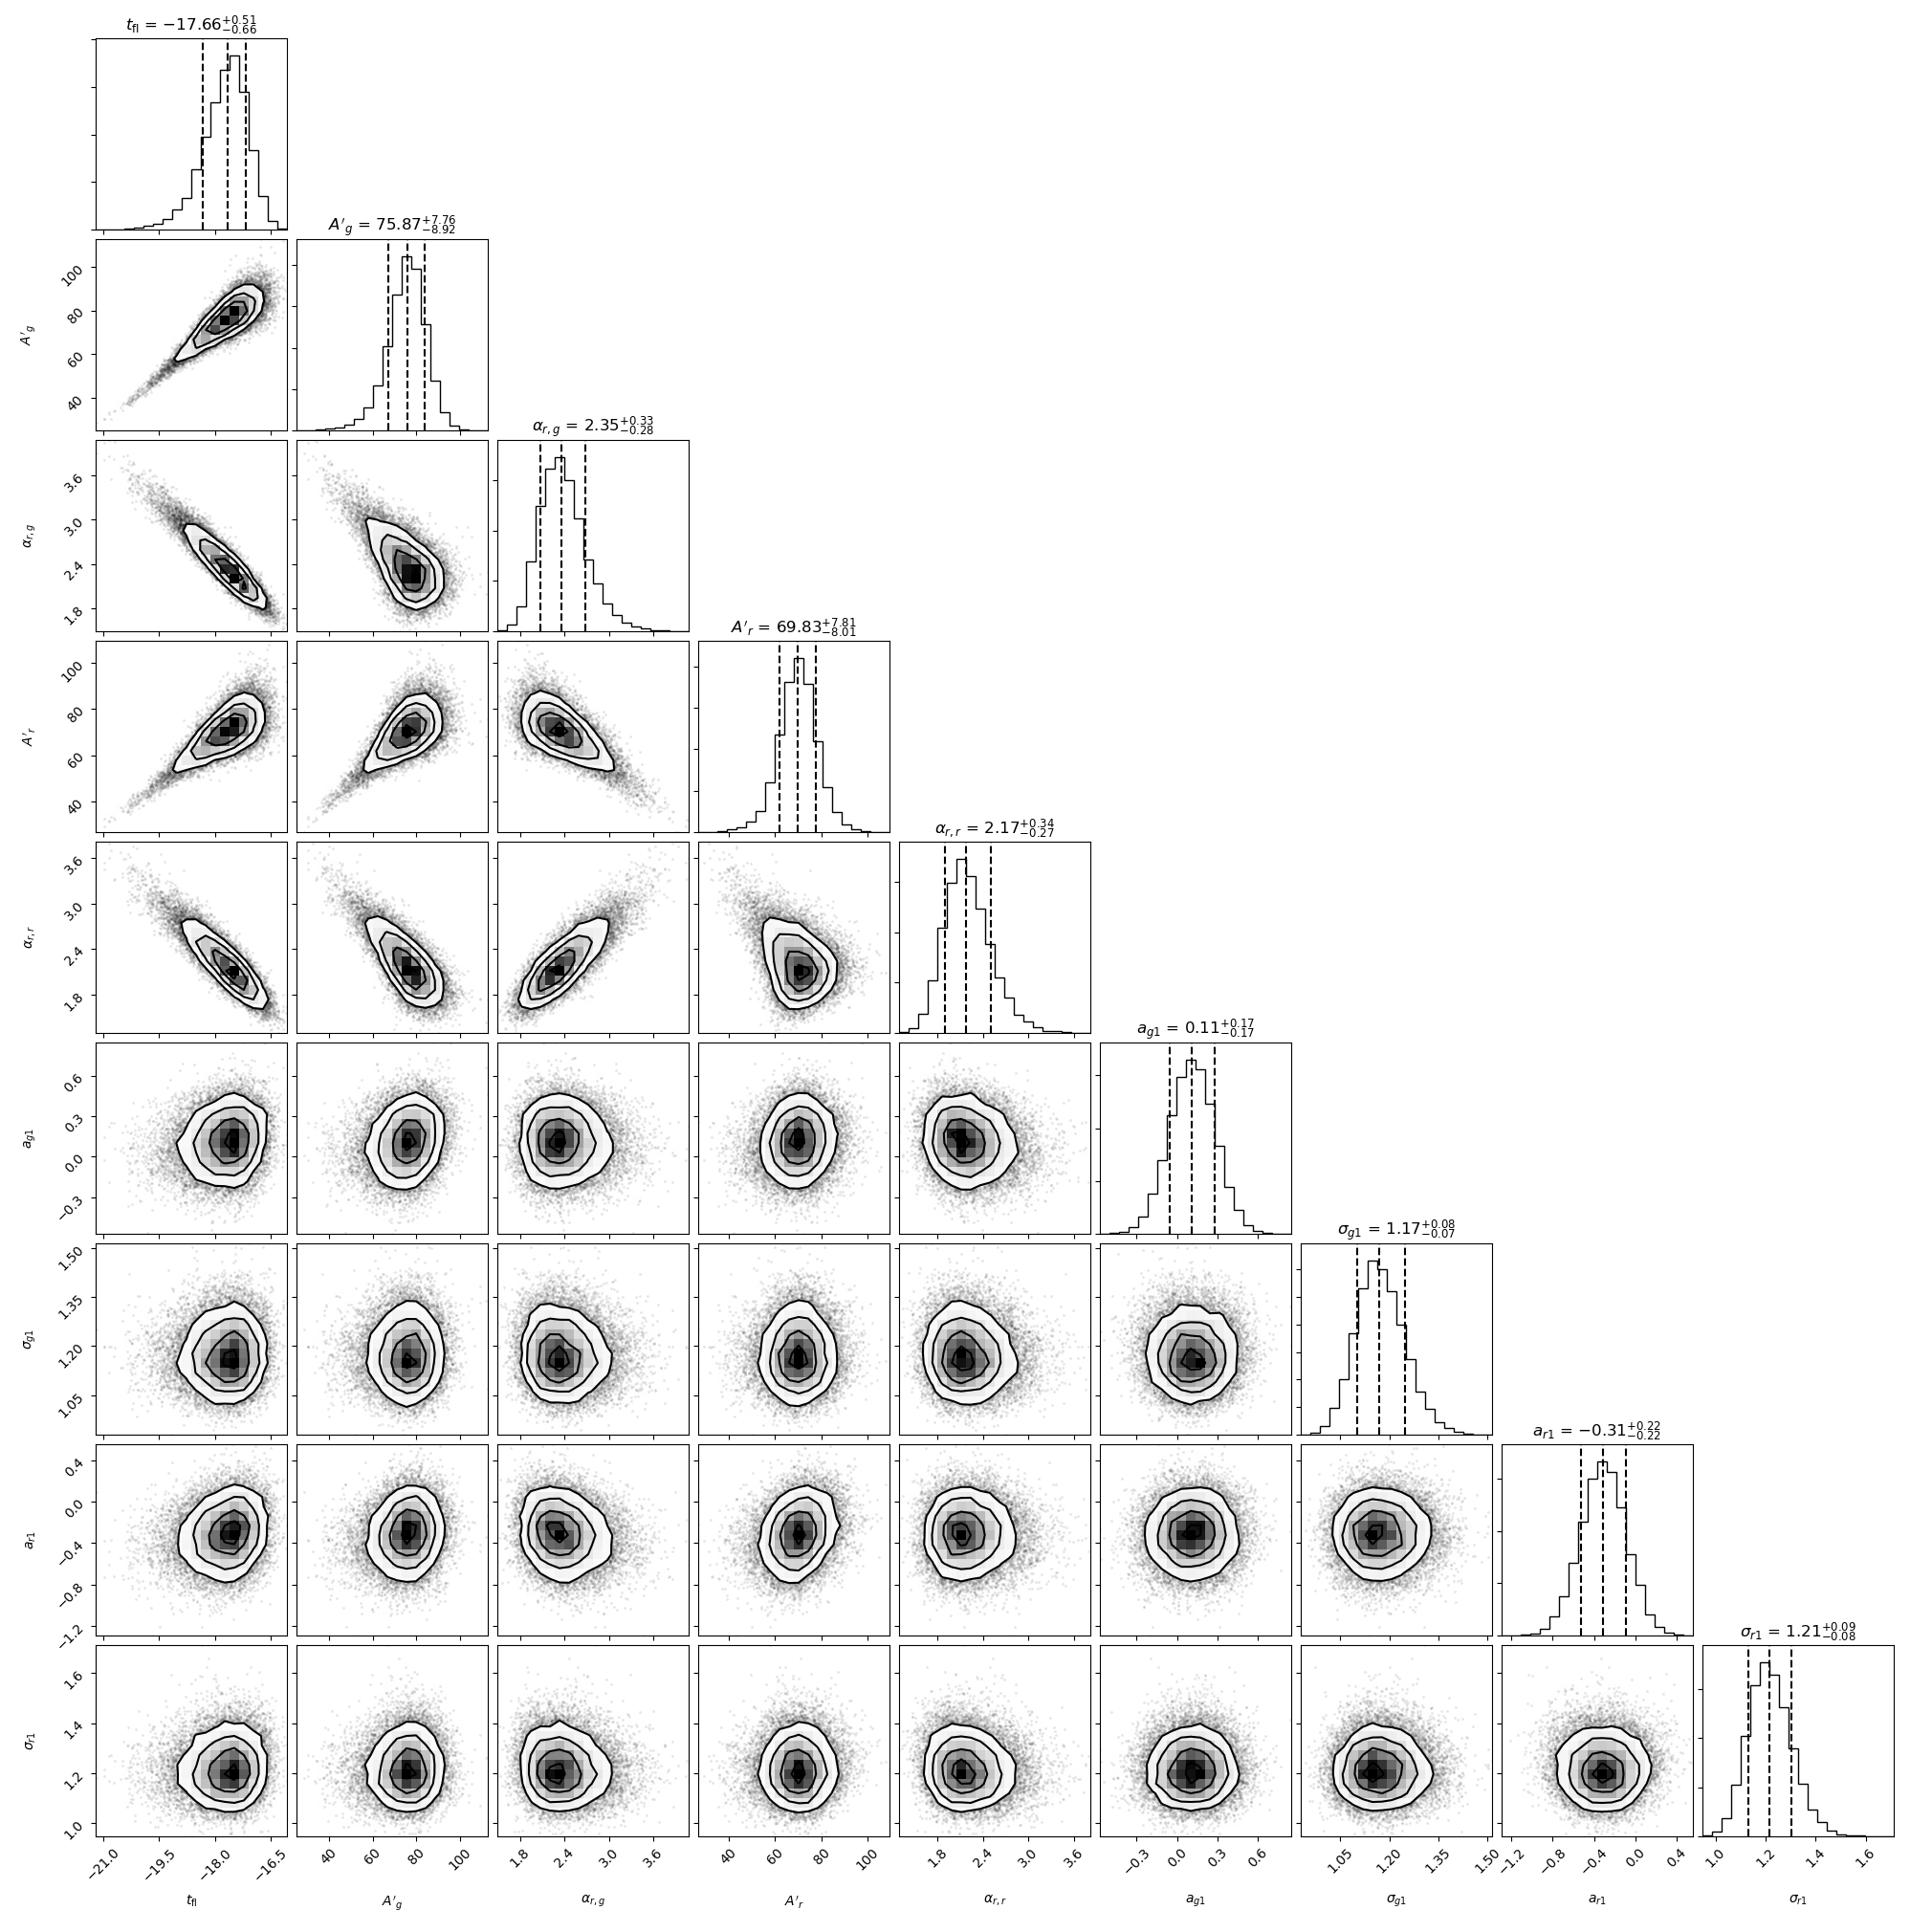

In [327]:
makeCorner(sampler, 200, gr_paramsNames)

In [328]:
samples = sampler.get_chain(discard=int(5*tau), flat=True)

<IPython.core.display.Javascript object>


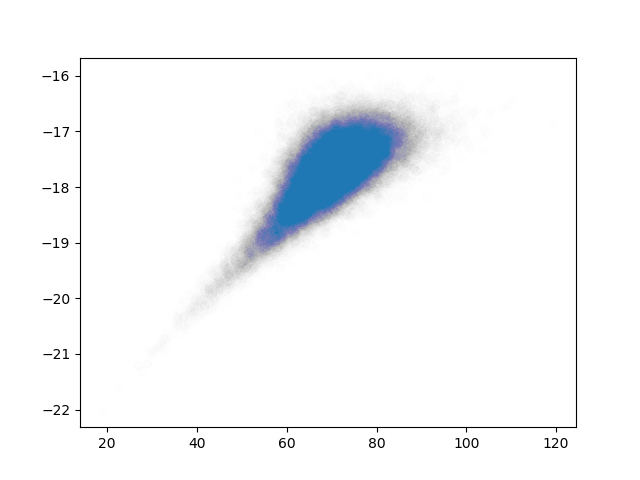

/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


In [330]:
t0 = samples[:,0]
A = samples[:,3]
alpha = samples[:,4]
plt.figure()
plt.plot(A, t0, 'o', alpha=0.002)
# plt.plot(A/np.exp(t0), t0, 'o', alpha=0.02)

grid = np.linspace(20,5000,1e7)
# plt.plot(grid, np.log(grid) - 26)

<IPython.core.display.Javascript object>


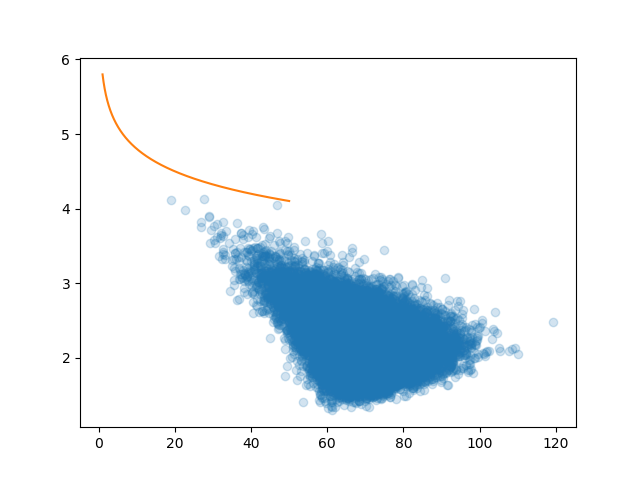

/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """


In [331]:
plt.figure()
plt.plot(A, alpha, 'o', alpha=0.2)
# plt.plot(A*10**(alpha), alpha, 'o', alpha=0.02)

grid = np.linspace(1,50,1e7)
plt.plot(grid, -np.log10(grid) + 5.8)

In [89]:
#define funtion to make corner plot
def makeCorner(sampler, nburn, paramsNames, quantiles=[0.16, 0.5, 0.84], truths=[]):
    samples = sampler.get_chain(discard=nburn, flat=True)
    if len(truths) > 0:
        f = corner.corner(samples, labels = paramsNames, quantiles = quantiles, 
                          truths=truths, plot_datapoints=False)
    else:
        f = corner.corner(samples, labels = paramsNames, quantiles = quantiles, 
                          show_titles=True, plot_datapoints=True)
    
#define function to plot walker chains  
def plotChains(sampler, nburn, paramsNames, nplot=nwalkers):
    Nparams = len(paramsNames)
    fig, ax = plt.subplots(Nparams+1,1, figsize = (8,2*(Nparams+1)), sharex = True)
    fig.subplots_adjust(hspace = 0)
    ax[0].set_title('Chains')
    xplot = np.arange(sampler.get_chain().shape[0])

    selected_walkers = np.random.choice(range(sampler.get_chain().shape[1]), nplot, replace=False)
    for i,p in enumerate(paramsNames):
        for w in selected_walkers:
            burn = ax[i].plot(xplot[:nburn], sampler.get_chain()[:nburn,w,i], 
                              alpha = 0.4, lw = 0.7, zorder = 1)
            ax[i].plot(xplot[nburn:], sampler.get_chain(discard=nburn)[:,w,i], 
                       color=burn[0].get_color(), alpha = 0.8, lw = 0.7, zorder = 1)
            
            ax[i].set_ylabel(p)
            if i==Nparams-1:
                ax[i+1].plot(xplot[:nburn], sampler.get_log_prob()[:nburn,w], 
                             color=burn[0].get_color(), alpha = 0.4, lw = 0.7, zorder = 1)
                ax[i+1].plot(xplot[nburn:], sampler.get_log_prob(discard=nburn)[:,w], 
                             color=burn[0].get_color(), alpha = 0.8, lw = 0.7, zorder = 1)
                ax[i+1].set_ylabel('ln P')
            
    return ax

gr_paramsNames=[r'$t_\mathrm{fl}$', 
             '$a_g$', r"$A'_g$", r'$\alpha_{r, g}$']